### Khởi tạo post_df và replies_df

In [28]:
import pandas as pd
import numpy as np
import json 
from dateutil.parser import isoparser
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

posts_df = pd.read_csv("cleaned_posts.csv")
replies_df = pd.read_csv('cleaned_replies.csv')

### Phân tích nội dung thuần


#### 1. Sử dụng `wordcloud` để biễu diễn cơ bản về những `keyword` sẽ xuất hiện trong bài đăng của người dùng.


In [29]:
from collections import Counter
import re
from nltk import ngrams

# Kết hợp tất cả văn bản từ cột 'originalContent'
all_text = " ".join(content for content in posts_df.originalContent)

# Chuyển tất cả văn bản thành chữ thường và loại bỏ các ký tự đặc biệt
all_text = re.sub(r'\W+', ' ', all_text.lower())

# Tách văn bản thành các từ riêng lẻ
words = all_text.split()

# Tạo các bigrams (cặp từ)
bigrams = ngrams(words, 2)

# Đếm tần suất xuất hiện của các bigrams
bigram_counts = Counter(bigrams)

# Chuyển đổi kết quả thành dataframe để dễ dàng xử lý
bigram_counts_df = pd.DataFrame(bigram_counts.items(), columns=['bigram', 'count']).sort_values(by='count', ascending=False)

# Hiển thị 20 bigrams phổ biến nhất
bigram_counts_df.head(20)

,bigram,count
511,"(thị, trường)",33382
36,"(cổ, phiếu)",28756
1371,"(đầu, tư)",18350
546,"(có, thể)",14908
296,"(giao, dịch)",13278
487,"(chứng, khoán)",11266
1744,"(anh, em)",10454
402,"(hôm, nay)",10278
955,"(hỗ, trợ)",9684
565,"(tiếp, tục)",9382


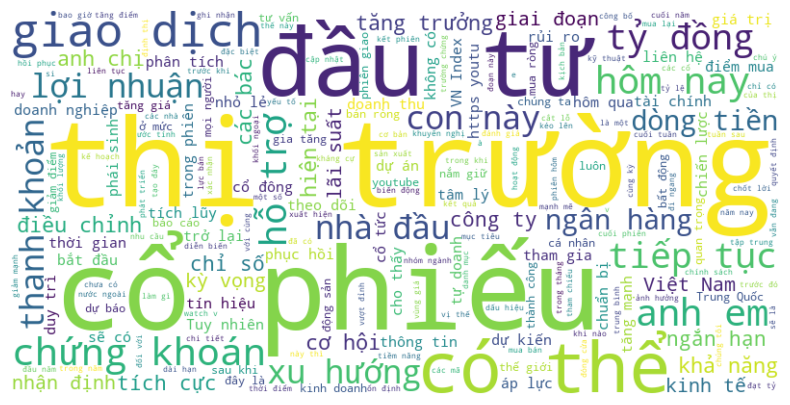

In [30]:

# Kết hợp tất cả văn bản từ cột 'originalContent'
text = " ".join(content for content in posts_df.originalContent)

# Tạo wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Nhận xét:
- Ngoài `cổ phiếu`, `giao dịch`, `thị trường` thì có 1 số keyword đáng chú ý là `thanh khoản`, `điểm mua`, `kỳ vọng` là những keyword đáng chú ý.

#### 2. Đặt vấn đề về những đường link có xuất hiện trong nội dung của các bài viết. 

Để phân tích ta sẽ sử dụng thư viện `re` để tìm các đường link trong cột `originalContent` của dataframe `posts_df`.

In [31]:

import re

# Tìm tất cả các đường link trong cột 'originalContent'
posts_df['links'] = posts_df['originalContent'].apply(lambda x: re.findall(r'(https?://\S+)', x))

# Chuyển sentiment từ dạng số sang string
posts_df['sentiment'] = posts_df['sentiment'].astype('string')
posts_df['sentiment'] = posts_df['sentiment'].replace({'1': 'positive', '0': 'neutral', '-1': 'negative'})

# Tạo một dataframe mới chỉ chứa các bài viết có đường link
links_df = posts_df.explode('links')[['date', 'postID', 'links', 'sentiment']].dropna().reset_index(drop=True)

links_df
# Trích xuất loại links từ cột 'links'
links_df['links'] = links_df['links'].apply(lambda x: x.replace('youtu.be', 'youtube.com') if 'youtu.be' in x else x)
links_df['link_type'] = links_df['links'].apply(lambda x: re.search(r'https?://(?:www\.)?([^/]+)', x).group(1) if re.search(r'https?://(?:www\.)?([^/]+)', x) else None)

links_df


,date,postID,links,sentiment,link_type
0,2024-11-06T21:38:45.743+07:00,29104016,https://www.youtube.com/live/rfLkHPX-CJo?si=5x...,neutral,youtube.com
1,2024-11-06T21:38:26.107+07:00,29104004,https://chungkhoannhatrang.vn/khanh-hoa-ban-ha...,neutral,chungkhoannhatrang.vn
2,2024-11-06T21:35:57.05+07:00,29103932,https://youtube.com/shorts/rH3OON8pU2A?si=8wCa...,neutral,youtube.com
3,2024-11-06T21:33:38.58+07:00,29103860,https://www.youtube.com/watch?v=5Aj7jDO1VSY&t=11s,positive,youtube.com
4,2024-11-06T21:28:34.473+07:00,29103739,https://youtube.com/clip/UgkxkjaCQ0bGfS64zvuSt...,neutral,youtube.com
...,...,...,...,...,...
10648,2024-09-06T10:17:02.76+07:00,28009227,https://youtube.com/live/aIB78pZQilg?feature=s...,neutral,youtube.com
10649,2024-09-06T10:14:16.993+07:00,28009092,https://f247.com/t/hpg-cho-doi-lan-gio-chinh-s...,neutral,f247.com
10650,2024-09-06T10:12:48.367+07:00,28009016,https://youtube.com/wERiDcK2BNA?si=aa3TpE65HYR...,neutral,youtube.com
10651,2024-09-06T10:11:00.183+07:00,28008910,https://f247.com/t/vn-index-dung-de-nghi-ngo-l...,neutral,f247.com


Mã trên sẽ tạo một dataframe `links_df` chứa các đường link và mã bài viết tương ứng.

In [32]:
# Lập bảng thống kê số lượng links theo loại
link_type_counts = links_df['link_type'].value_counts().reset_index()
link_type_counts.columns = ['link_type', 'count']
link_type_counts

,link_type,count
0,youtube.com,7899
1,vt.tiktok.com,334
2,baomoi.com,269
3,fireant.vn,185
4,f247.com,149
...,...,...
363,soha.vn,1
364,finance.vietstock.vn,1
365,ximangsaison.com,1
366,onsenfuji.com.vn,1


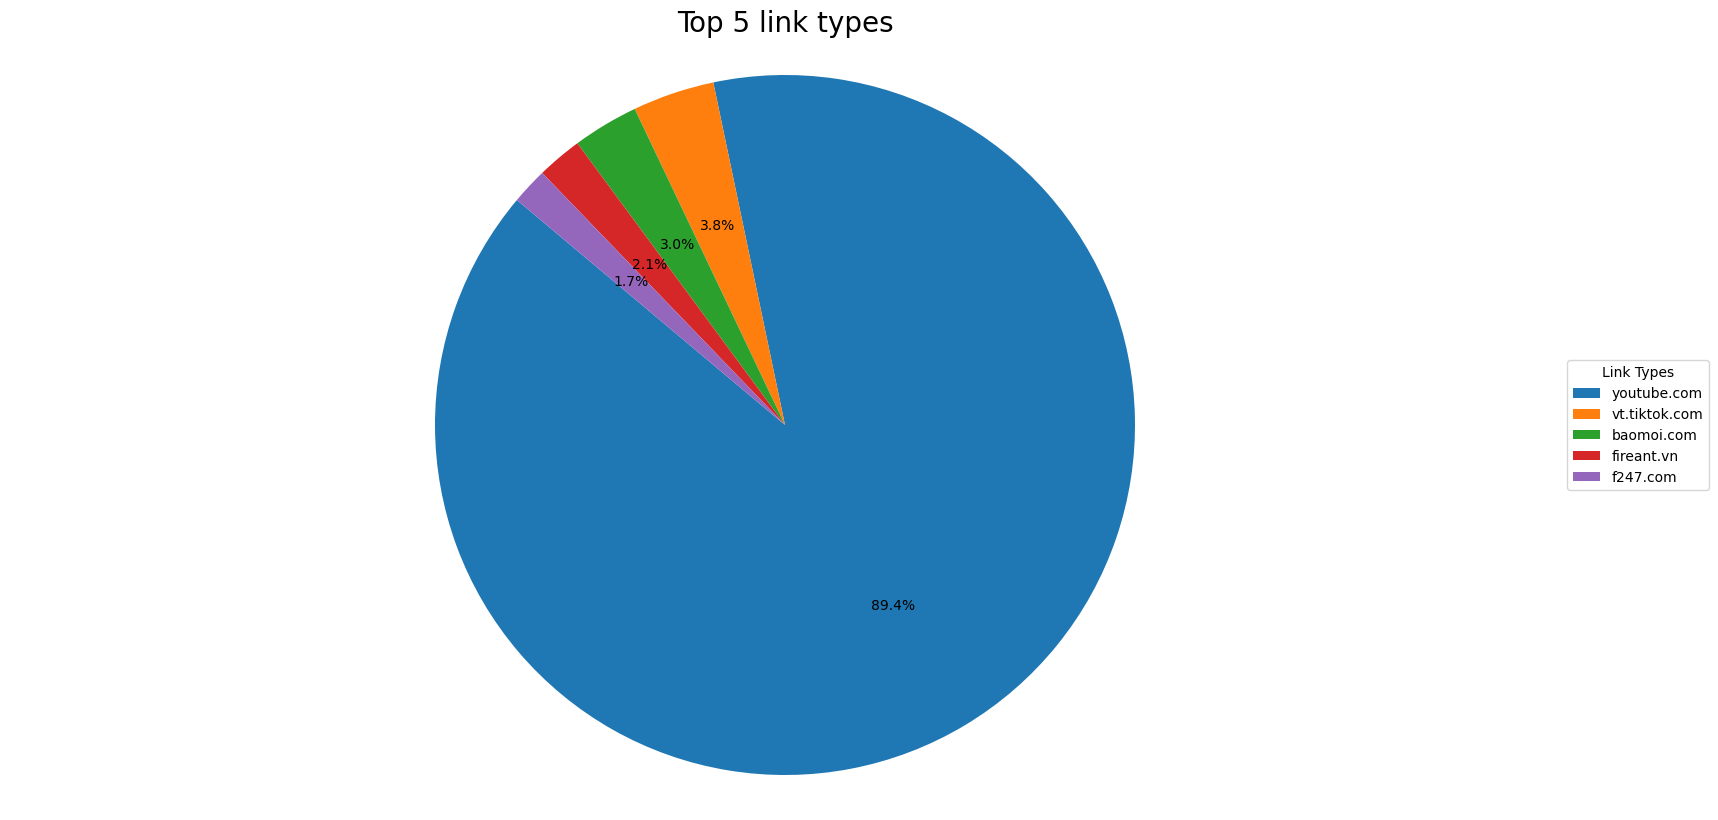

In [33]:
# Lấy 5 loại link phổ biến nhất
top_5_links = link_type_counts['link_type'][:5].tolist()

# Thay thế các loại link ít phổ biến bằng 'others'
links_df['link_type'] = links_df['link_type'].apply(lambda x: x if x in top_5_links else 'others')

# Lập pie chart biểu diễn 5 links có lượt xuất hiện cao nhất
plt.figure(figsize=(20, 10))
wedges, texts, autotexts = plt.pie(link_type_counts['count'][:5], labels=None, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Top 5 link types').set_fontsize(20)

# Thêm bảng chú thích
plt.legend(wedges, link_type_counts['link_type'][:5], title="Link Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Căn chỉnh các nhãn và tỷ lệ phần trăm cho đẹp hơn
for text in texts:
    text.set_fontsize(15)
for autotext in autotexts:
    autotext.set_fontsize(10)
plt.show()



Có thể thấy rằng đa số các liên kết trong bài viết đều dẫn đến các trang web bên ngoài, trong đó có nhiều liên kết đến `youtube.com`.

Vậy ta có thể kết luận rằng người dùng thường chia sẻ các liên kết đến các trang web bên ngoài như `youtube.com` trong các bài viết của mình.


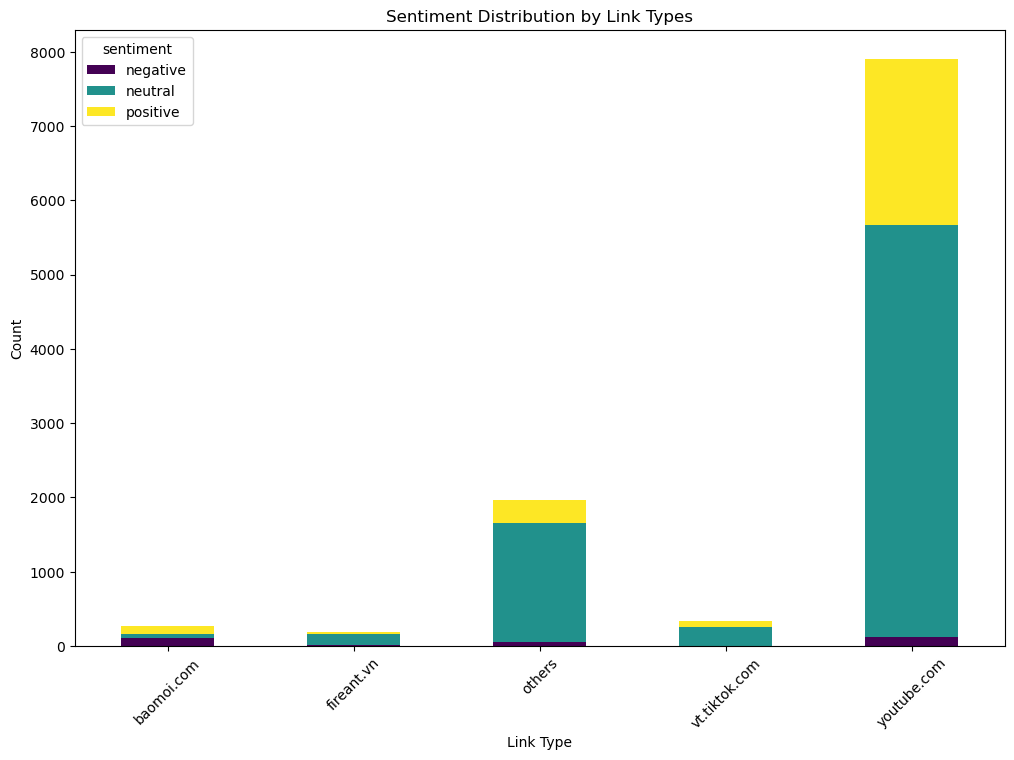

In [34]:
# Lấy 4 loại link phổ biến nhất
top_4_links = link_type_counts['link_type'][:4].tolist()

# Thay thế các loại link ít phổ biến bằng 'others'
links_df['link_type'] = links_df['link_type'].apply(lambda x: x if x in top_4_links else 'others')

# Tạo bảng tương quan giữa các loại liên kết
link_correlation = links_df.pivot_table(index='link_type', columns='sentiment', aggfunc='size', fill_value=0)

# Lọc các loại link cần thiết
filtered_links_df = links_df[links_df['link_type'].isin(top_4_links + ['others'])]

# Tạo bảng tương quan giữa các loại liên kết và sentiment
link_sentiment_correlation = filtered_links_df.pivot_table(index='link_type', columns='sentiment', aggfunc='size', fill_value=0)

# Vẽ biểu đồ cột
link_sentiment_correlation.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 8))
plt.title('Sentiment Distribution by Link Types')
plt.xlabel('Link Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Nhận thấy ta có thể phân tích tỉ lệ 3 sentiment của các `link_type`. Từ đó lựa chọn heatmap để thể hiện.

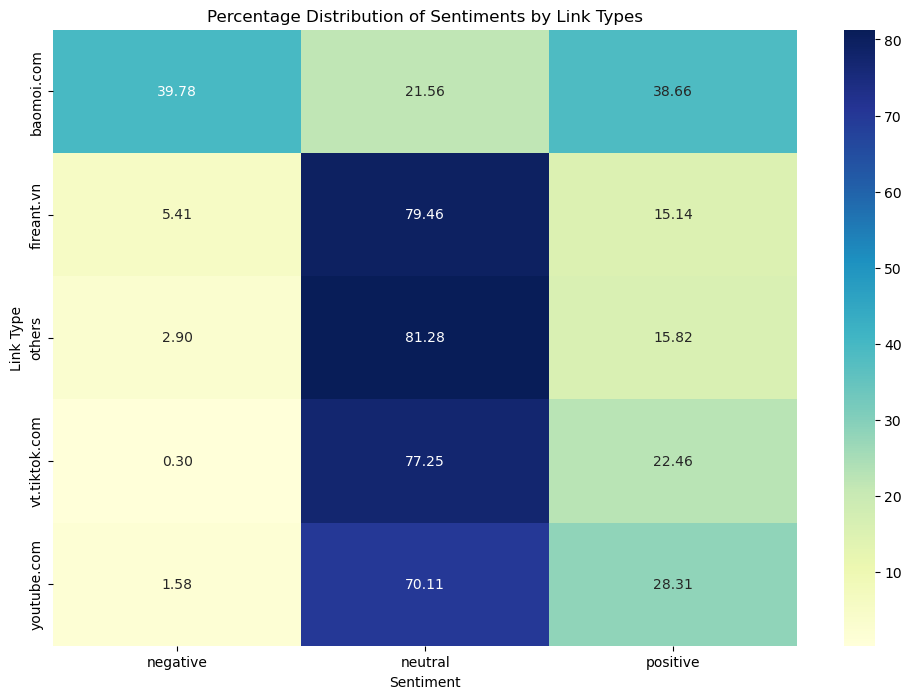

In [35]:
top_4_links = link_type_counts['link_type'][:4].tolist()

# Thay thế các loại link ít phổ biến bằng 'others'
links_df['link_type'] = links_df['link_type'].apply(lambda x: x if x in top_4_links else 'others')

# Tạo bảng tương quan giữa các loại liên kết và sentiment
link_correlation = links_df.pivot_table(index='link_type', columns='sentiment', aggfunc='size', fill_value=0)

# Tính tỷ lệ phần trăm
link_correlation_percentage = link_correlation.div(link_correlation.sum(axis=1), axis=0) * 100

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.heatmap(link_correlation_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Percentage Distribution of Sentiments by Link Types')
plt.xlabel('Sentiment')
plt.ylabel('Link Type')
plt.show()

Từ `Sentiment Distribution by Link Types` và `Percentage Distribution of Sentiments by Link Types`, có thể nhận xét như sau:

1. **Youtube.com**: Đây là loại liên kết phổ biến nhất và có sự phân bố đều giữa các loại sentiment. Đặc biệt, số lượng liên kết có sentiment tích cực (positive) và trung lập (neutral) chiếm ưu thế hơn so với tiêu cực (negative).

2. **Vt.tiktok.com**: Loại liên kết này chủ yếu có sentiment trung lập và tích cực, với số lượng sentiment trung lập chiếm phần lớn.

3. **Baomoi.com**: Số lượng liên kết từ baomoi.com có sentiment tiêu cực và tích cực gần như tương đương, trong khi sentiment trung lập ít hơn.

4. **Fireant.vn**: Loại liên kết này chủ yếu có sentiment trung lập, với số lượng sentiment tiêu cực và tích cực ít hơn.

5. **Others**: Các liên kết khác ngoài top 4 chủ yếu có sentiment trung lập, nhưng cũng có một số lượng đáng kể sentiment tích cực và tiêu cực.

Nhìn chung, các liên kết từ youtube.com và vt.tiktok.com và fireant.vn có xu hướng mang lại sentiment tích cực và trung lập nhiều hơn, trong khi các liên kết từ baomoi.com có sự phân bố sentiment đa dạng hơn.

phân tích độ liên kết của linktype và chỉ số thị trường như VNINDEX, VN30, HNINDEX, UPCOM

có thể là thời điểm số lần linktype ( cột ) xuất hiện và chỉ số VNINDEX như nào ( dạng line )

In [76]:
# Chuyển đổi cột 'date' sang định dạng datetime
links_df['date'] = pd.to_datetime(links_df['date'], format='ISO8601')

# Tôi cần 1 df biểu diễn số lần link_type xuất hiện theo ngày
link_type_counts_by_date = links_df.groupby([pd.Grouper(key='date', freq='D'), 'link_type']).size().reset_index()
link_type_counts_by_date.columns = ['date', 'link_type', 'count']

# Định dạng lại cột 'date'
link_type_counts_by_date['date'] = link_type_counts_by_date['date'].dt.strftime('%m-%d')

link_type_counts_by_date


,date,link_type,count
0,09-06,baomoi.com,1
1,09-06,fireant.vn,1
2,09-06,others,27
3,09-06,vt.tiktok.com,4
4,09-06,youtube.com,77
...,...,...,...
301,11-06,baomoi.com,2
302,11-06,fireant.vn,4
303,11-06,others,35
304,11-06,vt.tiktok.com,8


In [135]:
# Đọc dữ liệu từ csv trong folder price
vnindex_prices = pd.read_csv('price/VNINDEX.csv')
vn30_prices = pd.read_csv('price/VN30.csv')
hnxindex_prices = pd.read_csv('price/HNXINDEX.csv')

# Chuyển cột 'date' sang định dạng datetime
vn30_prices['time'] = pd.to_datetime(vn30_prices['time'], format='%Y-%m-%d %H:%M:%S')
hnxindex_prices['time'] = pd.to_datetime(hnxindex_prices['time'], format='%Y-%m-%d %H:%M:%S')
vnindex_prices['time'] = pd.to_datetime(vnindex_prices['time'], format='%Y-%m-%d %H:%M:%S')

In [147]:
# Tạo dataframe mới chứa ngày và giá trị lớn nhất của volume của VN30, VNINDEX, HNXINDEX
max_volume_by_date_vn30 = vn30_prices.groupby(vn30_prices['time'].dt.date)['volume'].max().reset_index()
max_volume_by_date_vnindex = vnindex_prices.groupby(vnindex_prices['time'].dt.date)['volume'].max().reset_index()
max_volume_by_date_hnxindex = hnxindex_prices.groupby(hnxindex_prices['time'].dt.date)['volume'].max().reset_index()

# Đổi tên các cột cho dễ hiểu
max_volume_by_date_vn30.columns = ['date', 'max_volume_vn30']
max_volume_by_date_vnindex.columns = ['date', 'max_volume_vnindex']
max_volume_by_date_hnxindex.columns = ['date', 'max_volume_hnxindex']

# Gộp các dataframe lại với nhau
max_volume_by_date_all = max_volume_by_date_vn30.merge(max_volume_by_date_vnindex, on='date').merge(max_volume_by_date_hnxindex, on='date')

print(max_volume_by_date_all)

          date  max_volume_vn30  max_volume_vnindex  max_volume_hnxindex
0   2024-09-04         43203501           107648224              9078400
1   2024-09-05         74655088           152696998             12524800
2   2024-09-06         57432919           105859600              8514100
3   2024-09-09         31003606            85108600             11320700
4   2024-09-10         68568612           148917900             11505400
5   2024-09-11         33748197           108707300              7476200
6   2024-09-12         39533397            88695200              5835700
7   2024-09-13         57289236           114944036              7021700
8   2024-09-16         63951745           149204544              7132500
9   2024-09-17         89175608           182374270             11667900
10  2024-09-18         83029644           152196200              9073300
11  2024-09-19         50863034           111745164              7234400
12  2024-09-20         71616900           145318300

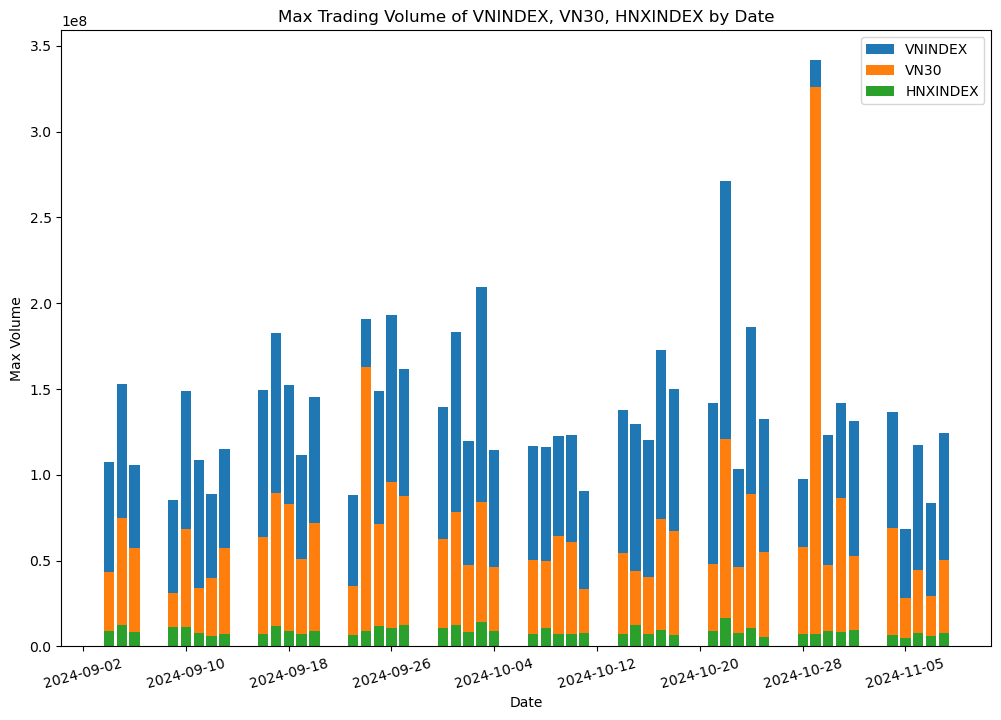

In [152]:
# Tạo column chart thể hiện max_volume_by_date của thị trường VNINDEX, VN30, HNXINDEX theo ngày
plt.figure(figsize=(12, 8))
plt.bar(max_volume_by_date_all['date'], max_volume_by_date_all['max_volume_vnindex'], label='VNINDEX')
plt.bar(max_volume_by_date_all['date'], max_volume_by_date_all['max_volume_vn30'], label='VN30')
plt.bar(max_volume_by_date_all['date'], max_volume_by_date_all['max_volume_hnxindex'], label='HNXINDEX')
plt.title('Max Trading Volume of VNINDEX, VN30, HNXINDEX by Date')
plt.xlabel('Date')
plt.ylabel('Max Volume')
plt.legend()

plt.xticks(rotation=15)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.show()


Nhận xét:
- Có thể thấy rằng đa số các liên kết trong bài viết đều dẫn đến các trang web bên ngoài, trong đó có nhiều liên kết đến `youtube.com`.
- Vậy ta có thể kết luận rằng người dùng thường chia sẻ các liên kết đến các trang web bên ngoài như `youtube.com` trong các bài viết của mình.


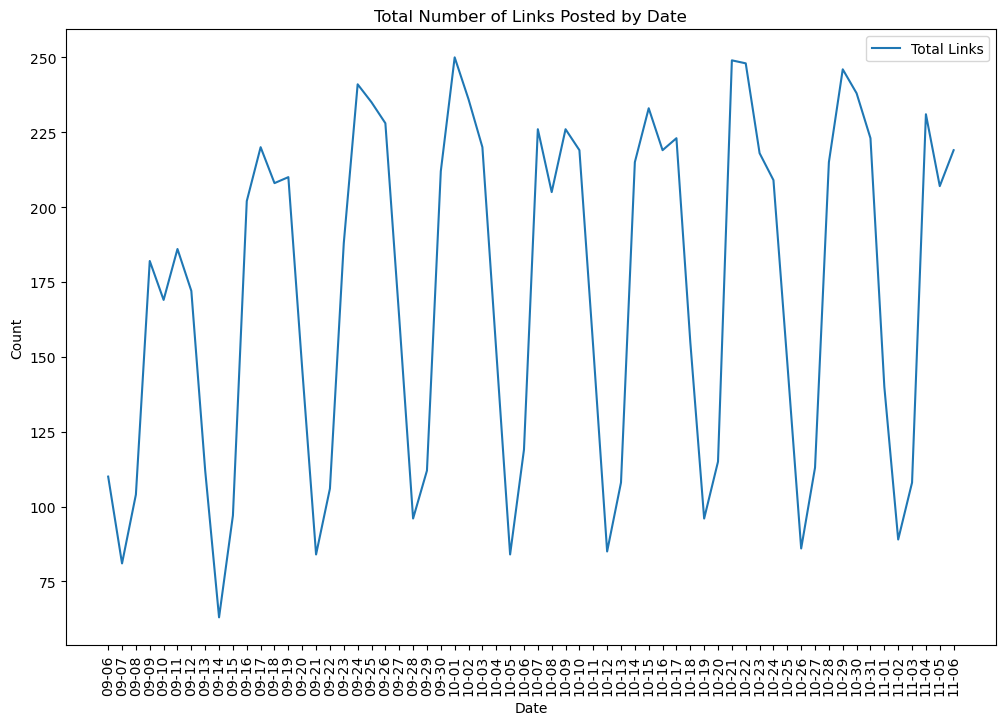

In [125]:
# Tạo chart số lần xuất hiện của tất cả các loại link theo ngày
total_link_counts_by_date = link_counts_by_date.groupby('date')['count'].sum().reset_index()

# Tạo line chart thể hiện số lần xuất hiện của tất cả các loại link theo ngày
plt.figure(figsize=(12, 8))
plt.plot(total_link_counts_by_date['date'], total_link_counts_by_date['count'], label='Total Links')

plt.title('Total Number of Links Posted by Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend()
plt.show()


Nhận thấy có vẻ số lần xuất hiện link có tương quan rất lớn với lượng giao dịch cổ phiếu.

Khi số lượng link được đề cập tăng (đặc biệt nếu là các tin tức quan trọng), khối lượng giao dịch có thể tăng do:

1. Nhà đầu tư chú ý và phản ứng với thông tin.

2. Sự kiện thu hút dòng vốn mới vào cổ phiếu liên quan.

**Ngược lại**, nếu một cổ phiếu ít được chú ý (số lượng link ít), khả năng khối lượng giao dịch sẽ thấp do sự quan tâm ít hơn.

#### 3. Phân tích mỗi tương quan của sự tương tác trên bài viết và các yếu tố khác của bài viết.

In [ ]:
# Tạo một dataframe mới chứa các bài viết, độ dài bài viết, tổng lượt like, tổng lượt phản hồi, sentiment
posts_summary = posts_df[['date', 'postID', 'originalContent', 'sentiment', 'taggedSymbols']]
posts_summary['post_length'] = posts_summary['originalContent'].apply(lambda x: len(x))
posts_summary['total_likes'] = posts_df['totalLikes']
posts_summary['total_replies'] = posts_df['totalReplies']

# Săp xếp dataframe theo số lượng lượt like giảm dần
posts_summary = posts_summary.sort_values(by='total_likes', ascending=False).reset_index(drop=True)
posts_summary.head(20)

# Nhận thấy các bài viết tổng hợp của ngày là những bài có lượng tương tác cao, và lượt bình luận cao.

C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_3640\4033142696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_summary['post_length'] = posts_summary['originalContent'].apply(lambda x: len(x))
C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_3640\4033142696.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_summary['total_likes'] = posts_df['totalLikes']
C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_3640\4033142696.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

,date,postID,originalContent,sentiment,taggedSymbols,post_length,total_likes,total_replies
0,2024-10-24T15:19:54.307+07:00,28869167,Phái Sinh ngày 24/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 42514.95}, {""symb"":...",836,69,125
1,2024-09-26T20:35:36.153+07:00,28352578,XU HƯỚNG TTCK QUÝ 4. 2024\n\nĐể xác định xu hư...,neutral,"[{""symb"": ""^DJI"", ""price"": 42166.66}, {""symb"":...",5785,68,15
2,2024-10-28T15:21:13.823+07:00,28923357,Phái Sinh ngày 28/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 42114.4}, {""symb"": ...",839,63,64
3,2024-10-22T19:47:48.227+07:00,28821151,Hy vọng năm sau tôi và các bạn sẽ cùng nhau cổ...,neutral,"[{""symb"": ""BSR"", ""price"": 21.3}, {""symb"": ""DXG...",5372,62,31
4,2024-10-03T15:27:47.05+07:00,28483887,Phái Sinh ngày 3/10/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""$BTC"", ""price"": 61459.01}, {""symb"":...",774,62,151
5,2024-10-22T15:19:18.6+07:00,28817167,Phái Sinh ngày 22/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 42931.6}, {""symb"": ...",836,62,93
6,2024-09-17T15:26:44.7+07:00,28172493,Phái Sinh ngày 17/9/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""^DJI"", ""price"": 41622.08}, {""symb"":...",926,61,76
7,2024-10-15T15:21:31.533+07:00,28687978,Phái Sinh ngày 15/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 43065.22}, {""symb"":...",1195,60,82
8,2024-10-02T15:31:17.63+07:00,28457094,Phái Sinh ngày 2/10/2024\n.\n- Hnay Tây Long r...,neutral,"[{""symb"": ""$BTC"", ""price"": 61728.04}, {""symb"":...",784,59,88
9,2024-11-04T15:39:53.723+07:00,29054941,Phái Sinh ngày 4/11/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""^DJI"", ""price"": 42052.19}, {""symb"":...",837,57,118


Nhận xét:
- Có vẻ độ dài bài viết không ảnh hưởng j đến lượng tương tác nhưng từ `700-900` là 1 bài viết có khả năng đạt tương tác cao.

### Phân tích bình luận

#### 1. Tạo `wordcloud` từ `replies_df` để hiển thị các từ phổ biến trong phản hồi

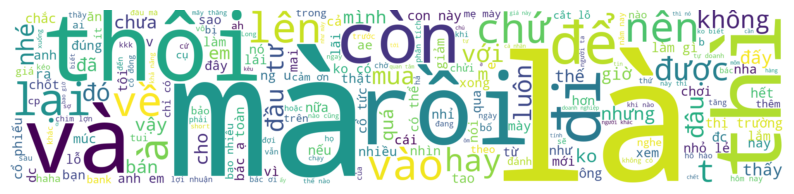

In [ ]:

# Kết hợp tất cả văn bản từ cột 'originalContent'
text_filtered = " ".join(content for content in replies_df.originalContent)

# Tạo wordcloud
wordcloud_filtered = WordCloud(width=2000, height=450, background_color='white').generate(text_filtered)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_filtered, interpolation='bilinear')
plt.axis('off')
plt.show()




### Tiêu chí đánh giá xu hướng

### Phân tích nhận định

In [ ]:
# Trích xuất mã từ cột 'taggedSymbols'
posts_df['symbols'] = posts_df['taggedSymbols'].apply(lambda x: [d['symb'] for d in eval(x)])

# Tạo một dataframe mới chứa các mã và sentiment
symbols_df = posts_df.explode('symbols')[['symbols', 'sentiment']]

# Đếm số lượng xuất hiện của mỗi mã
symbol_counts = symbols_df['symbols'].value_counts().reset_index()
symbol_counts.columns = ['symbol', 'count']

# Kết hợp với sentiment
result_df = symbols_df.groupby('symbols')['sentiment'].first().reset_index()
result_df = result_df.merge(symbol_counts, left_on='symbols', right_on='symbol').drop(columns=['symbols'])

# Sắp xếp theo lượt xuất hiện của mã giảm dần
result_df = result_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Xóa cột 'sentiment'
result_df = result_df.drop(columns=['sentiment'])

# Thêm các cột mới
result_df['positive'] = symbols_df[symbols_df['sentiment'] == 'positive'].groupby('symbols').size().reindex(result_df['symbol'], fill_value=0).values
result_df['neutral'] = symbols_df[symbols_df['sentiment'] == 'neutral'].groupby('symbols').size().reindex(result_df['symbol'], fill_value=0).values
result_df['negative'] = symbols_df[symbols_df['sentiment'] == 'negative'].groupby('symbols').size().reindex(result_df['symbol'], fill_value=0).values

result_df


,symbol,count,positive,neutral,negative
0,VNINDEX,55258,8919,42821,3518
1,HPG,13317,3204,9531,582
2,VHM,12117,1934,9547,636
3,VN30F1M,11448,2236,8551,661
4,DXG,10721,2355,7888,478
...,...,...,...,...,...
1476,FUESSV50,1,0,1,0
1477,TSG,1,1,0,0
1478,DCH,1,0,1,0
1479,MDC,1,0,1,0


C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_3640\3734963223.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(result_df['symbol'][:50], rotation=90)


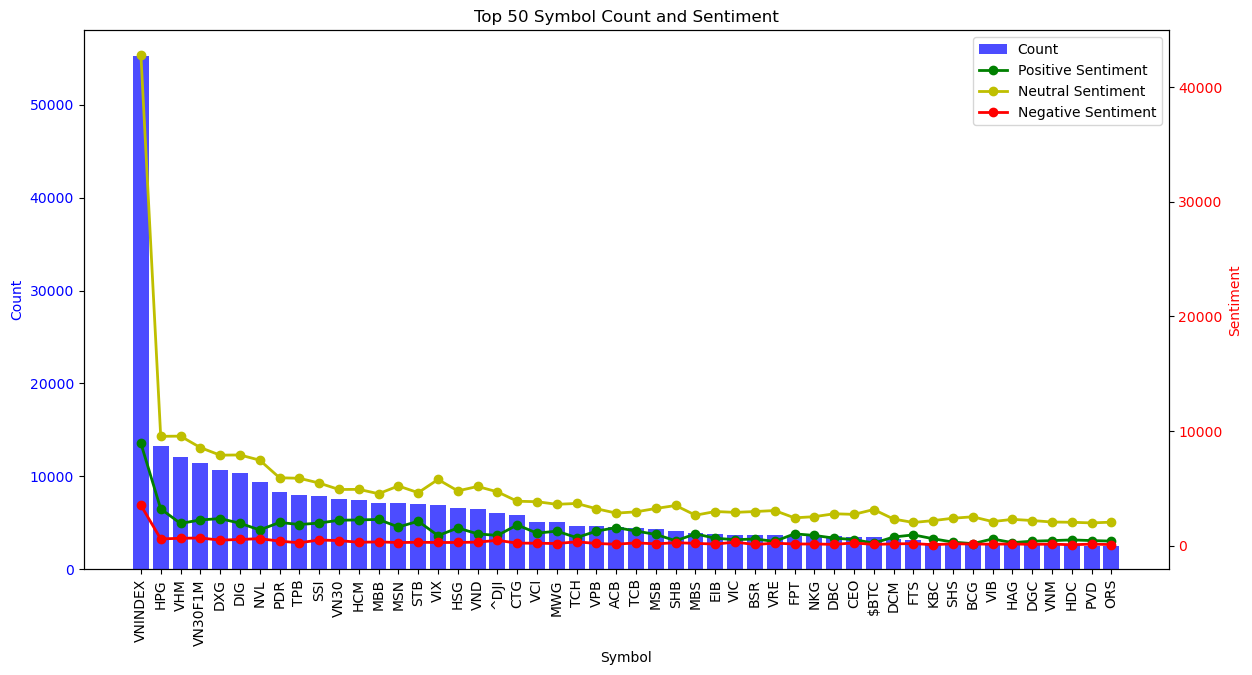

In [ ]:
# Vẽ biểu đồ cho cả 3 cột của result_df
fig, ax1 = plt.subplots(figsize=(14, 7))

# Vẽ biểu đồ cột cho số lượng xuất hiện của mỗi mã
ax1.bar(result_df['symbol'][:50], result_df['count'][:50], color='b', alpha=0.7, label='Count')
ax1.set_xlabel('Symbol')
ax1.set_ylabel('Count', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(result_df['symbol'][:50], rotation=90)

# Tạo một trục y thứ hai để vẽ sentiment
ax2 = ax1.twinx()
ax2.plot(result_df['symbol'][:50], result_df['positive'][:50], color='g', marker='o', linestyle='-', linewidth=2, label='Positive Sentiment')
ax2.plot(result_df['symbol'][:50], result_df['neutral'][:50], color='y', marker='o', linestyle='-', linewidth=2, label='Neutral Sentiment')
ax2.plot(result_df['symbol'][:50], result_df['negative'][:50], color='r', marker='o', linestyle='-', linewidth=2, label='Negative Sentiment')
ax2.set_ylabel('Sentiment', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Thêm bảng chú thích
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.title('Top 50 Symbol Count and Sentiment')
plt.show()